# Tree-based methods - predicting energy in each building

In [2]:
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

pd.set_option('mode.chained_assignment', None) # hide settingwithcopywarning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
data = pd.read_csv('data_more_time_features.csv')
data['Time'] = pd.to_datetime(data['Time'])
data = data.set_index('Time')

### Plot results

In [5]:
# plot prediction results
def plot_predictions(results, variables_to_pred):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    axes = axes.flatten()
    
    for idx, target in enumerate(variables_to_pred):
        # Get data from results dictionary
        y_test = results[target]['y_test']
        y_pred = results[target]['y_pred']
        rmse = results[target]['rmse']
        r2 = results[target]['r2']
        
        # Plot actual vs predicted
        ax = axes[idx]
        ax.plot(y_test.index, y_test, label='Actual', color='#4c72c7', alpha=0.7)
        ax.plot(y_test.index, y_pred, label='Predicted', color='#df4e52', linestyle='-', alpha=0.7)
        ax.set_title(f"Predictions for {target}\nRMSE: {rmse:.2f}, R²: {r2:.2f}", fontsize=16)
        ax.set_xlabel("Date", fontsize=14)
        ax.set_ylabel("kWh", fontsize=14)
        ax.tick_params(axis='both', labelsize=13)
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=90)
    
    plt.tight_layout()
    plt.show()
    return fig

In [6]:
# plot feature importances
def plot_feature_importances(all_results, feature_names, top_n=10):
    """
    Plots feature importances for each target in all_results.
    """
    for target, result in all_results.items():
        model = result['model']
        importances = model.feature_importances_
        sorted_idx = importances.argsort()[::-1][:top_n]  # Top-N importances

        plt.figure(figsize=(6, 4))
        fi_fig = sns.barplot(x=importances[sorted_idx], y=[feature_names[i] for i in sorted_idx], palette='deep')
        plt.title(f"RFR Feature Importance for: {target}", fontsize=14)
        plt.xlabel("Importance", fontsize=14)
        plt.ylabel("Feature", fontsize=14)
        plt.tick_params(axis='both', labelsize=14)
        plt.tight_layout()
        plt.savefig(f"RFR Feature importance - {target}.png", dpi=300, bbox_inches="tight")
        plt.show()

In [7]:
# Define targets
Y_sets = [['el_ur', 'district_heat_ur'],
          ['el_bikuben', 'district_heat_bikuben'],
          ['el_sor', 'district_heat_sor'],
          ['el_ka', 'district_heat_ka'],
          ['el_biotek', 'district_heat_biotek'],
          ['el_tf', 'district_heat_tf']]

# Combine all RFR targets
all_targets = [y for group in Y_sets for y in group]

# Drop all targets from X
X = data.drop(columns=all_targets)

## Random Forrest Regression (RFR)

#### With exhaustive grid search

In [10]:
def RFR(X, y, param_grid, target_name='target', plot=False):
    """
    Train and validate RandomForestRegressor using a 70/20/10 split.
    """
    # Get total number of samples
    n = len(X)
    train_end = int(n * 0.7)
    val_end = int(n * 0.9)

    # Manual split
    X_train = X.iloc[:train_end]
    X_val = X.iloc[train_end:val_end]
    X_test = X.iloc[val_end:]

    y_train = y.iloc[:train_end]
    y_val = y.iloc[train_end:val_end]
    y_test = y.iloc[val_end:]

    best_model = None
    best_params = None
    best_rmse = float('inf')

    # Step 3: Manual grid search over validation set
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        model = RandomForestRegressor(**params, random_state=42)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_val_pred, squared=False)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = params

    print(f"\nBest validation RMSE: {best_rmse:.4f}")
    print(f"Best parameters: {best_params}")

    # Step 4: Retrain on full train+val and evaluate on test
    X_trainval = pd.concat([X_train, X_val])
    y_trainval = pd.concat([y_train, y_val])
    final_model = RandomForestRegressor(**best_params, random_state=42)
    final_model.fit(X_trainval, y_trainval)

    y_pred = final_model.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_pred, squared=False)
    r2_test = r2_score(y_test, y_pred)

    print(f"\nTest RMSE: {rmse_test:.4f}")
    print(f"Test R²: {r2_test:.4f}")

    return final_model, y_test, y_pred, rmse_test, r2_test

In [11]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 50],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5, 10],       
    'min_samples_leaf': [1, 2, 4],            
    'bootstrap': [True, False]}          


In [12]:
# smaller parameter grid for testing

#param_grid = {'n_estimators': [300],
#            'max_features': ['sqrt'], 
#            'min_samples_split': [2],
#            'min_samples_leaf': [1],
#            'bootstrap': [True]}

In [13]:
# Store RFR results
all_results = {}

# Train RFR for all targets first
for target in all_targets:
    y = data[target]
    model, y_test, y_pred, rmse, r2 = RFR(X, y, param_grid, target_name=target)
    all_results[target] = {
        'model': model,
        'y_test': y_test,
        'y_pred': y_pred,
        'rmse': rmse,
        'r2': r2}


Best validation RMSE: 11.6650
Best parameters: {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': True}

Test RMSE: 6.6689
Test R²: 0.8617

Best validation RMSE: 37.8508
Best parameters: {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True}

Test RMSE: 21.1451
Test R²: 0.5602

Best validation RMSE: 5.1833
Best parameters: {'n_estimators': 100, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True}

Test RMSE: 3.7947
Test R²: 0.9070

Best validation RMSE: 8.6874
Best parameters: {'n_estimators': 300, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}

Test RMSE: 5.5935
Test R²: 0.4129

Best validation RMSE: 17.9079
Best parameters: {'n_estimators': 300, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_sa


--- Plotting RFR results for: ['el_ur', 'district_heat_ur'] ---


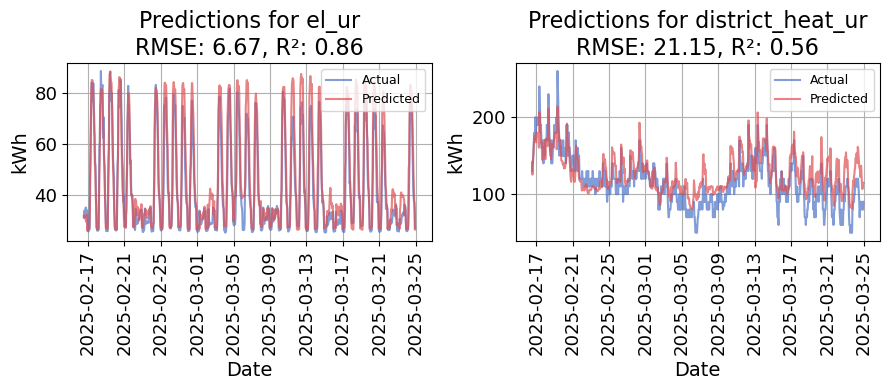


--- Plotting RFR results for: ['el_bikuben', 'district_heat_bikuben'] ---


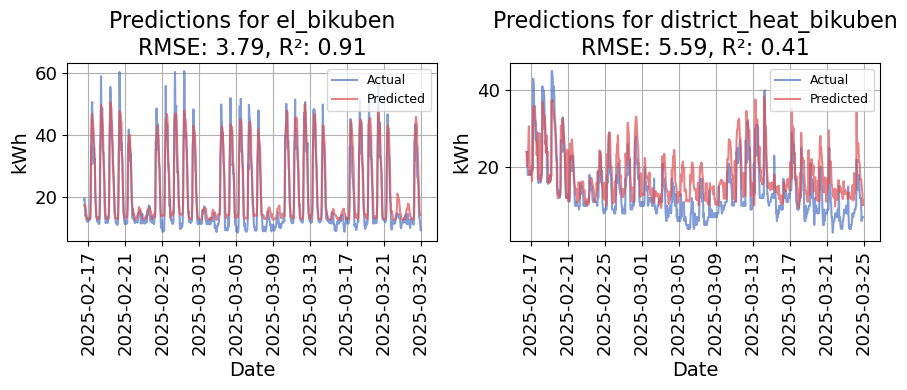


--- Plotting RFR results for: ['el_sor', 'district_heat_sor'] ---


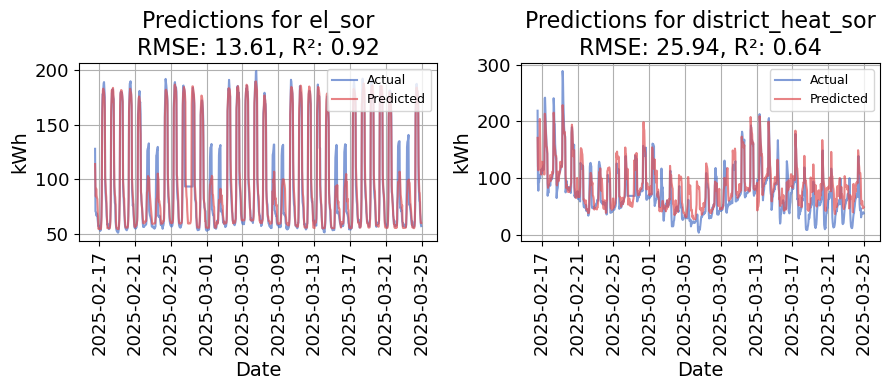


--- Plotting RFR results for: ['el_ka', 'district_heat_ka'] ---


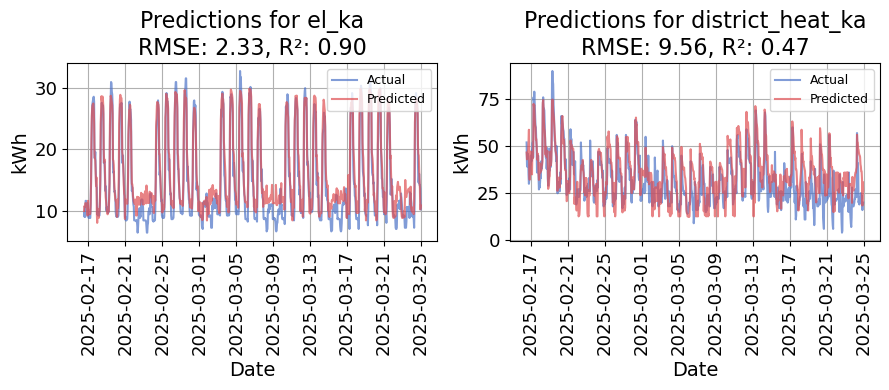


--- Plotting RFR results for: ['el_biotek', 'district_heat_biotek'] ---


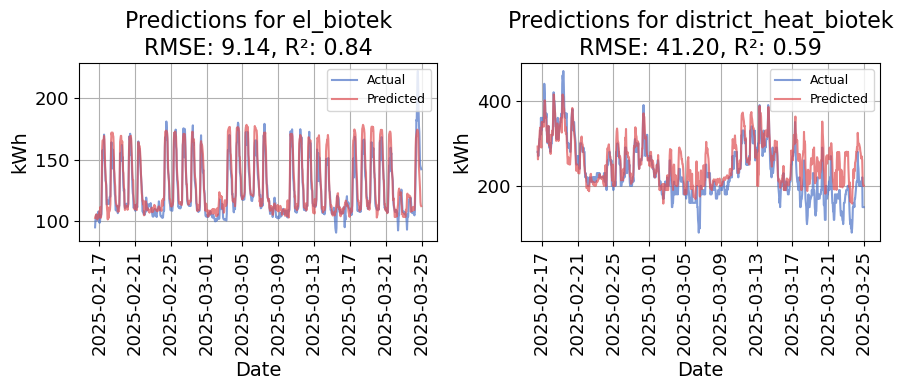


--- Plotting RFR results for: ['el_tf', 'district_heat_tf'] ---


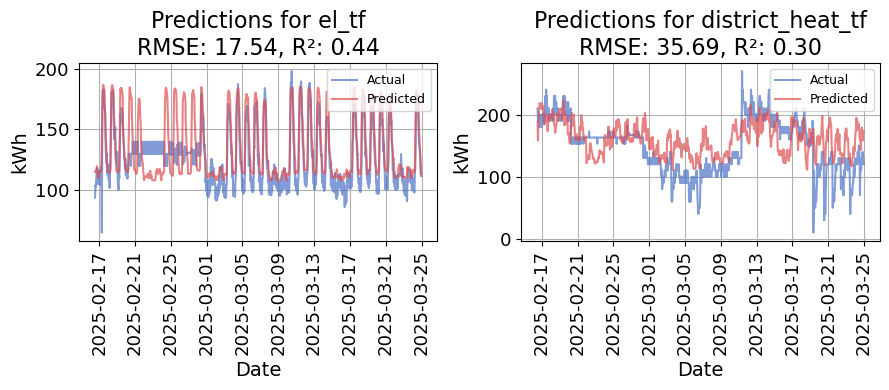

In [14]:
# Plot RFR
for y_columns in Y_sets:
    print(f"\n--- Plotting RFR results for: {y_columns} ---")
    results_subset = {k: all_results[k] for k in y_columns}
    fig = plot_predictions(results_subset, y_columns)
    #fig.savefig(f"RFR_{'_'.join(y_columns)}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

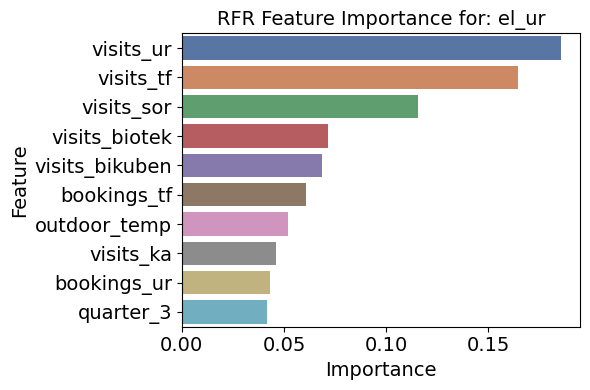

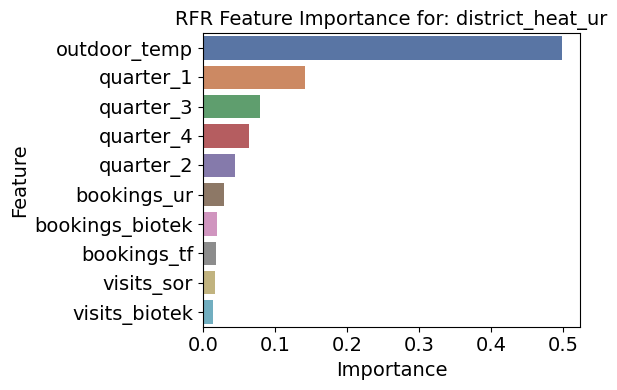

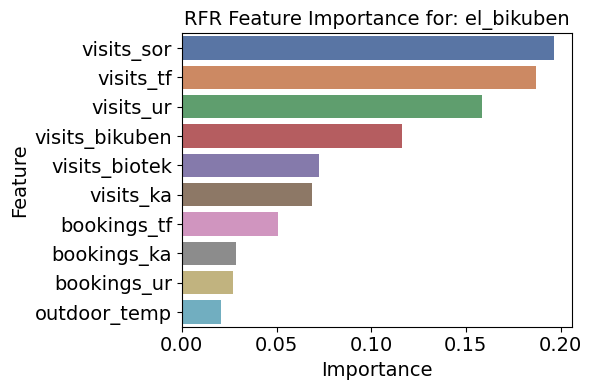

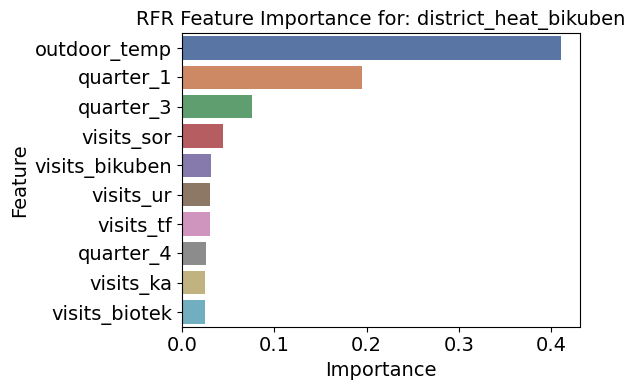

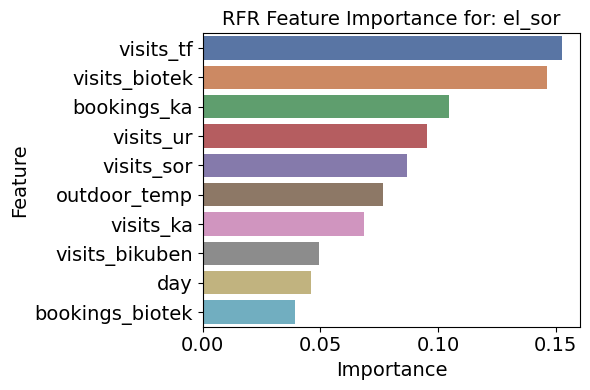

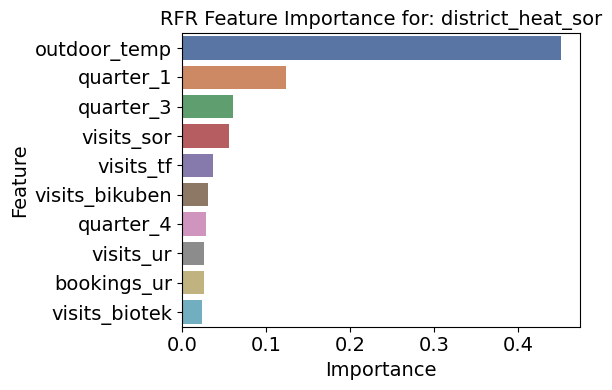

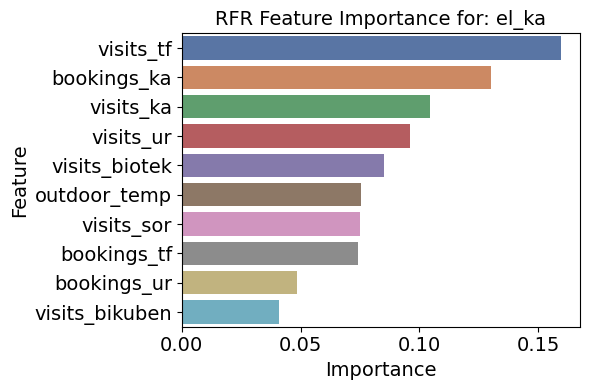

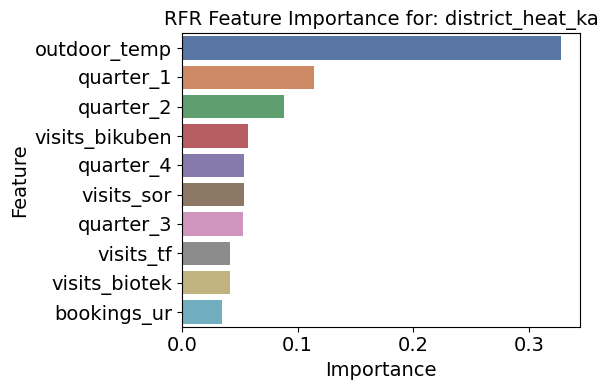

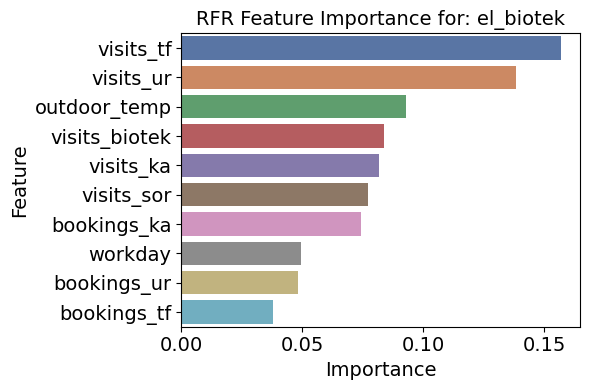

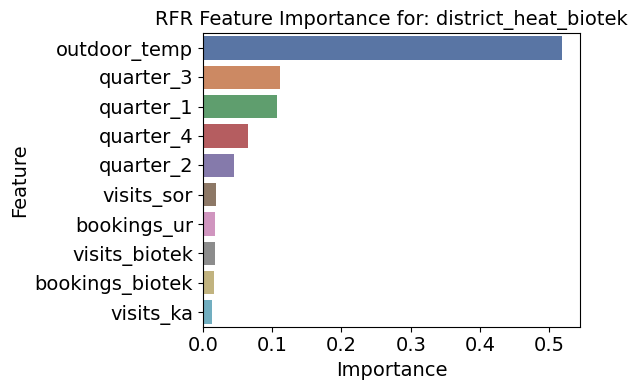

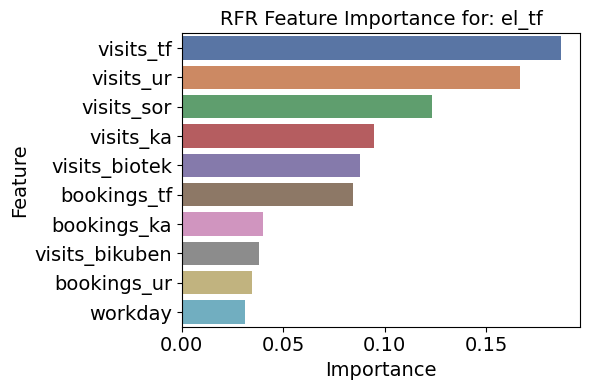

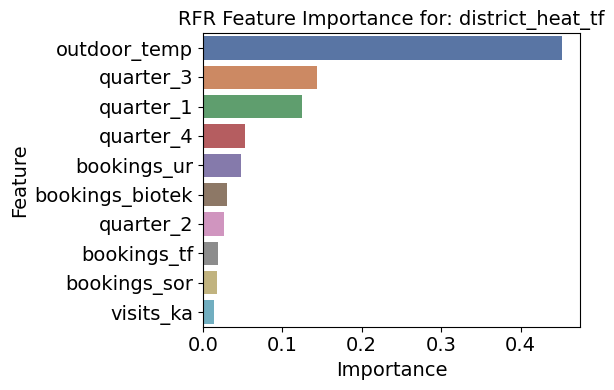

In [15]:
# plot RFR feature importance
plot_feature_importances(all_results, X.columns.tolist(), top_n=10)

## Gradient Boosting Regression (GBR)

In [17]:
def GBR(X, y, param_grid, target_name='target', plot=False):
    """
    Train and validate GradientBoostingRegressor using train/val/test splits.
    """
    # Get total number of samples
    n = len(X)
    train_end = int(n * 0.7)
    val_end = int(n * 0.9)

    # Manual split
    X_train = X.iloc[:train_end]
    X_val = X.iloc[train_end:val_end]
    X_test = X.iloc[val_end:]

    y_train = y.iloc[:train_end]
    y_val = y.iloc[train_end:val_end]
    y_test = y.iloc[val_end:]
    best_model = None
    best_params = None
    best_rmse = float('inf')

    # Step 3: Manual grid search over validation set
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        model = GradientBoostingRegressor(**params, random_state=42)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_val_pred, squared=False)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = params

    print(f"\nBest validation RMSE: {best_rmse:.4f}")
    print(f"Best parameters: {best_params}")

    # Step 4: Retrain on full train+val and evaluate on test
    X_trainval = pd.concat([X_train, X_val])
    y_trainval = pd.concat([y_train, y_val])
    final_model = GradientBoostingRegressor(**best_params, random_state=42)
    final_model.fit(X_trainval, y_trainval)

    y_pred = final_model.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_pred, squared=False)
    r2_test = r2_score(y_test, y_pred)

    print(f"\nTest RMSE: {rmse_test:.4f}")
    print(f"Test R²: {r2_test:.4f}")

    return final_model, y_test, y_pred, rmse_test, r2_test

In [18]:
# plot feature importances
def plot_feature_importances(all_results, feature_names, top_n=10):
    """
    Plots feature importances for each target in all_results.
    """
    for target, result in all_results.items():
        model = result['model']
        importances = model.feature_importances_
        sorted_idx = importances.argsort()[::-1][:top_n]  # Top-N importances

        plt.figure(figsize=(6, 4))
        fi_fig = sns.barplot(x=importances[sorted_idx], y=[feature_names[i] for i in sorted_idx], palette='deep')
        plt.title(f"GBR Feature Importance for: {target}", fontsize=14)
        plt.xlabel("Importance", fontsize=14)
        plt.ylabel("Feature", fontsize=14)
        plt.tick_params(axis='both', labelsize=14)
        plt.tight_layout()
        plt.savefig(f"GBR new Feature importance - {target}.png", dpi=300, bbox_inches="tight")
        plt.show()

In [19]:
# Parameter grid
param_grid = {
    'n_estimators': [100, 300],             # Number of trees
    'learning_rate': [0.01, 0.05, 0.1],     # How much each tree contributes
    'max_depth': [3, 5],                    # Tree depth
    'min_samples_split': [2, 5],            # Minimum samples to split an internal node
    'subsample': [1.0, 0.8]}                # Fraction of samples for fitting each base learner

In [20]:
# Store GBR results
all_results_GBR = {}

# Train GBR for all targets first
for target in all_targets:
    y = data[target]
    model, y_test, y_pred, rmse, r2 = GBR(X, y, param_grid, target_name=target)
    all_results_GBR[target] = {
        'model': model,
        'y_test': y_test,
        'y_pred': y_pred,
        'rmse': rmse,
        'r2': r2}


Best validation RMSE: 11.4008
Best parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'subsample': 0.8}

Test RMSE: 6.4218
Test R²: 0.8718

Best validation RMSE: 22.0899
Best parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'subsample': 0.8}

Test RMSE: 18.2036
Test R²: 0.6741

Best validation RMSE: 4.9978
Best parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'subsample': 0.8}

Test RMSE: 3.6731
Test R²: 0.9128

Best validation RMSE: 6.3179
Best parameters: {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'subsample': 0.8}

Test RMSE: 5.0674
Test R²: 0.5181

Best validation RMSE: 17.1445
Best parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 2, 'subsample': 0.8}

Test RMSE: 14.0823
Test R²: 0.9122

Best validation RMSE: 36.8880
Best parameters: {'n_estimators': 100, 


--- Plotting GBR results for: ['el_ur', 'district_heat_ur'] ---


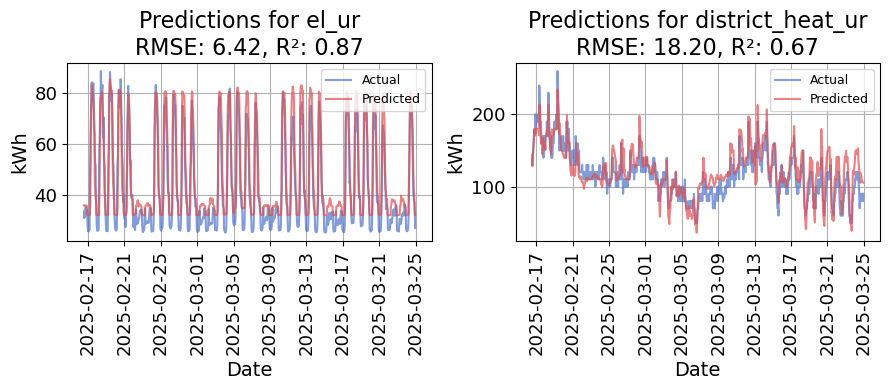


--- Plotting GBR results for: ['el_bikuben', 'district_heat_bikuben'] ---


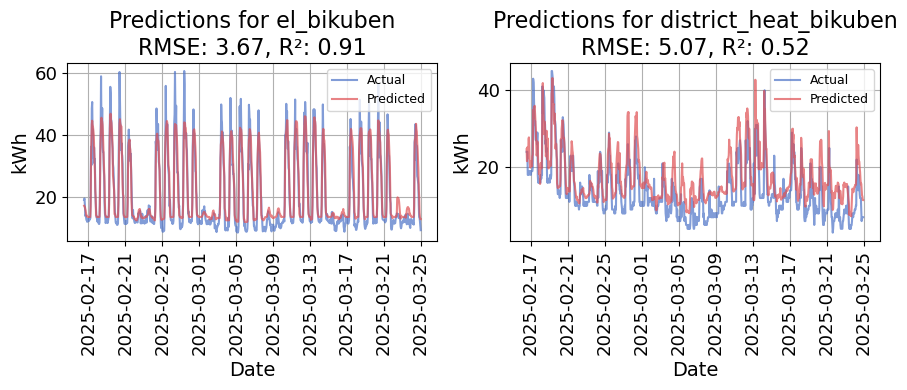


--- Plotting GBR results for: ['el_sor', 'district_heat_sor'] ---


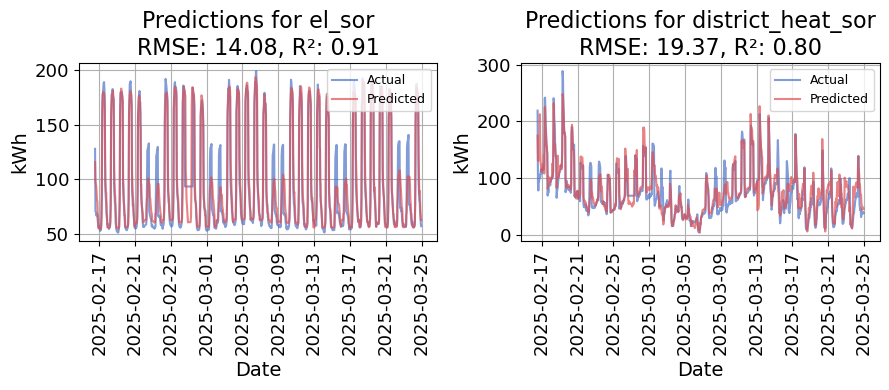


--- Plotting GBR results for: ['el_ka', 'district_heat_ka'] ---


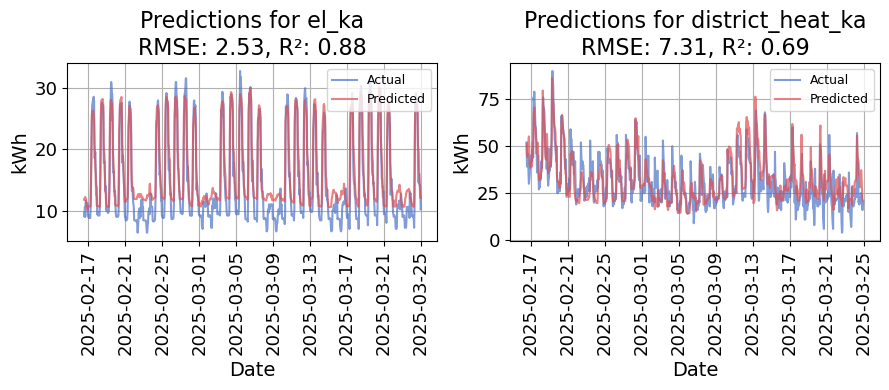


--- Plotting GBR results for: ['el_biotek', 'district_heat_biotek'] ---


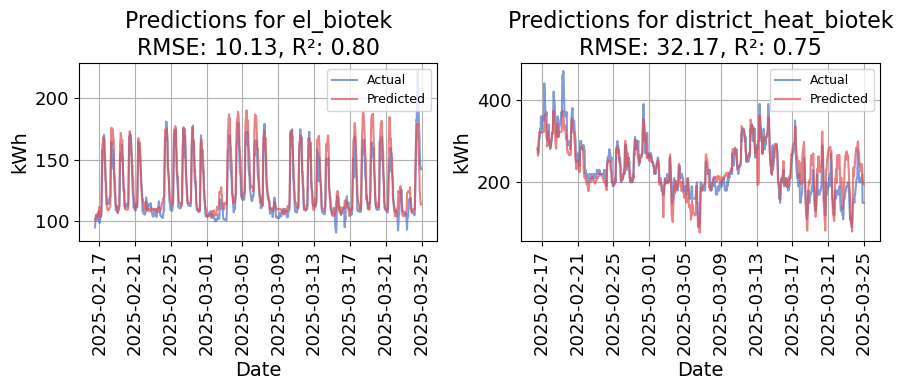


--- Plotting GBR results for: ['el_tf', 'district_heat_tf'] ---


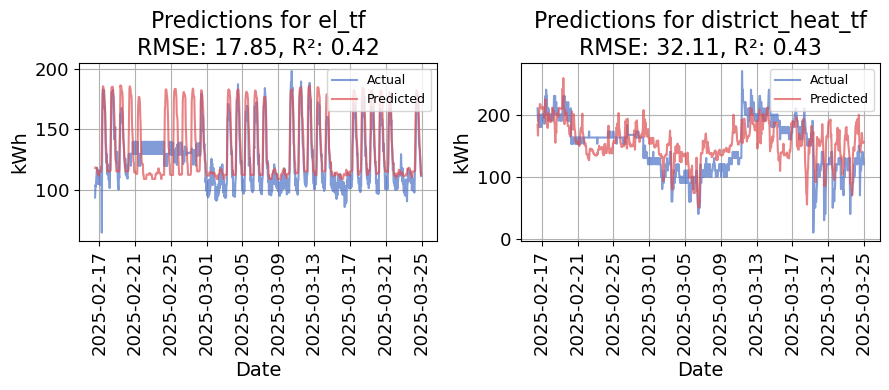

In [21]:
# Plot  GBR predictions
for y_columns in Y_sets:
    print(f"\n--- Plotting GBR results for: {y_columns} ---")
    results_subset = {k: all_results_GBR[k] for k in y_columns}
    fig = plot_predictions(results_subset, y_columns)

    # Optional: save or close the figure
    fig.savefig(f"GBR_new{'_'.join(y_columns)}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

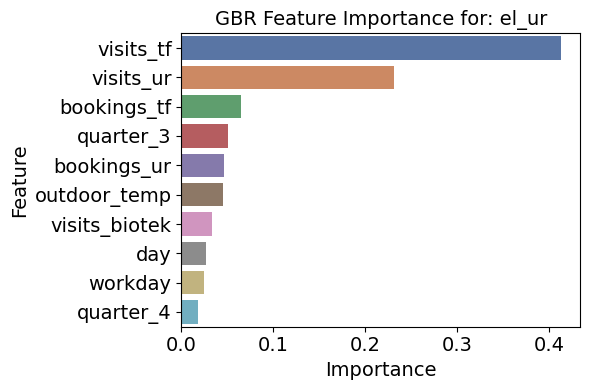

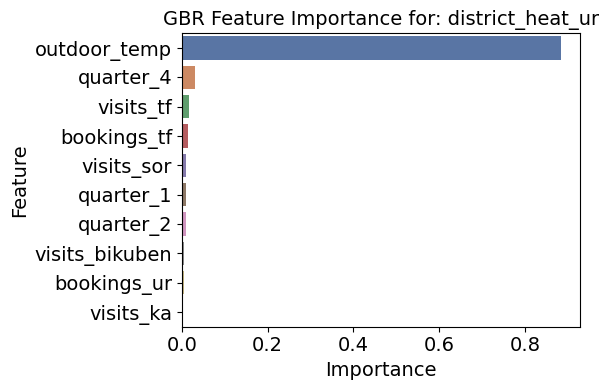

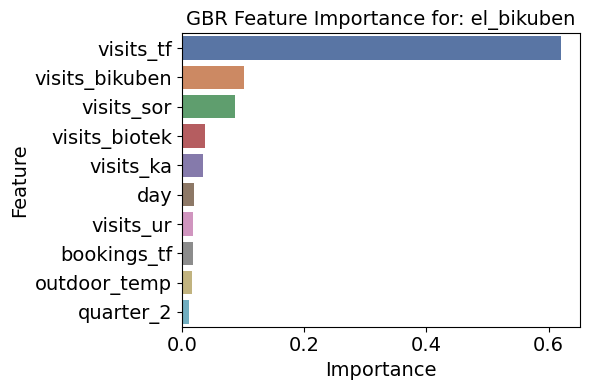

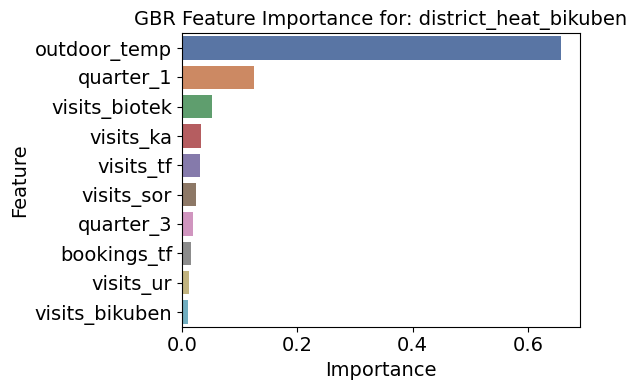

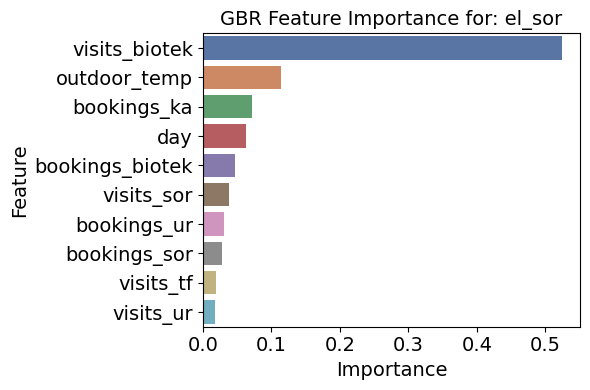

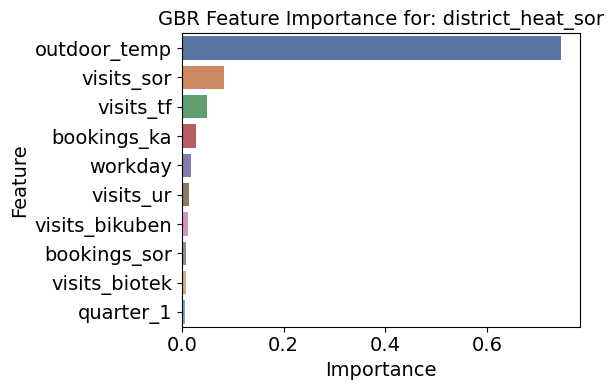

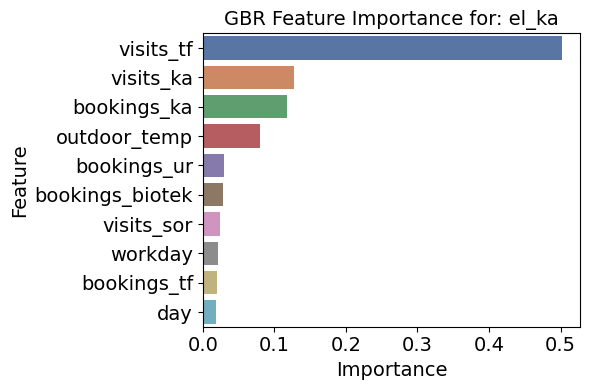

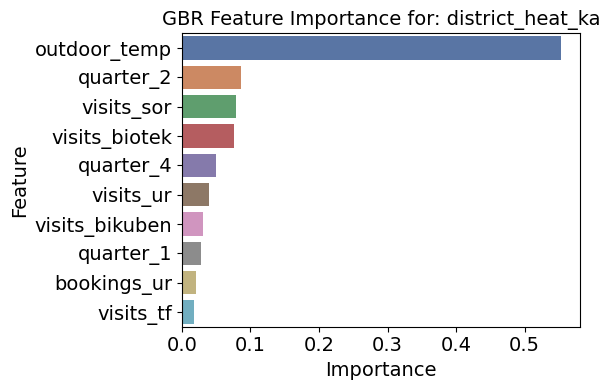

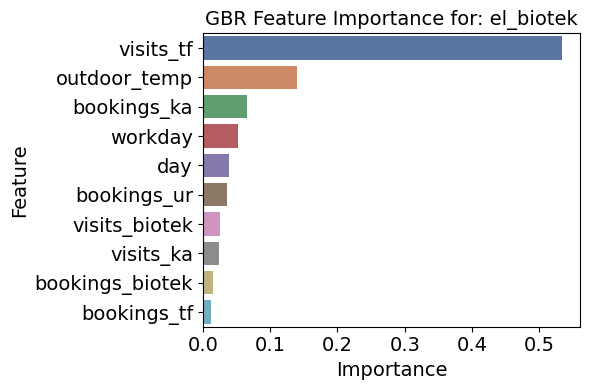

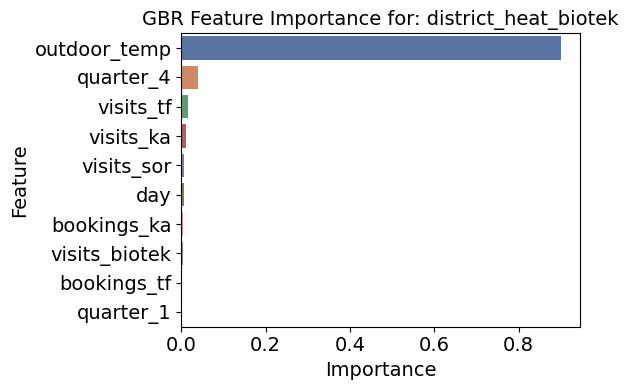

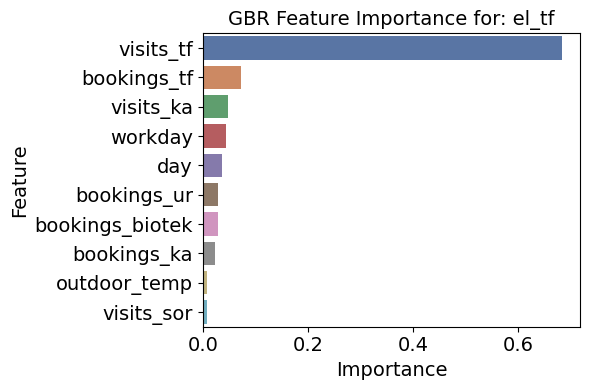

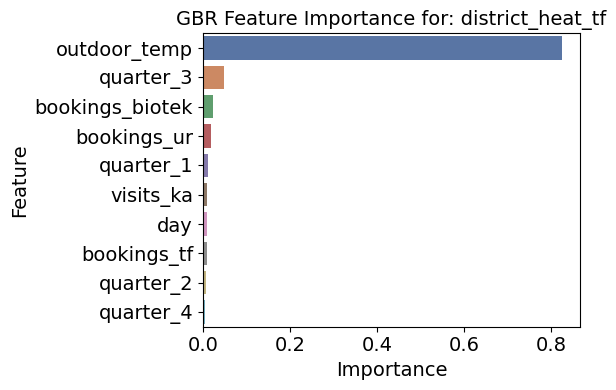

In [22]:
# plot RFR feature importance
plot_feature_importances(all_results_GBR, X.columns.tolist(), top_n=10)